In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import *
import pandas as pd

In [2]:
def mat(theta, phi):
    return np.matrix([[cos(theta), sin(theta)*exp(-1j*phi)],
                      [sin(theta)*exp(1j*phi), -cos(theta)]])

In [3]:
def normalized_dot_product(a,b):
    prod = np.vdot(a.tolist()[0],b.tolist()[0])
    return prod/np.abs(prod)

In [4]:
ROUNDING_DIGITS = 5
problematic_vertexes = {378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 421}
class Point:
    def __init__(self, string):
        x,y,z = map(float,string.split()[:3])
        self.x, self.y, self.z  = x,y,z 
        self.theta = round(np.arccos(z/(x**2+y**2+z**2)), ROUNDING_DIGITS)
        self.phi = round(np.arctan2(x,y), ROUNDING_DIGITS)
        if self.phi < -pi*.8:
            self.phi += 2*pi
        self.matrix = mat(self.theta, self.phi)
        self.eig = np.linalg.eigh(self.matrix)
        self.vals = self.eig[0]
        self.vecs = self.eig[1].T
    def __repr__(self):
        return "<θ={},φ={}>".format(self.theta, self.phi)

class Vertex:
    def __init__(self, string):
        n = int(string.split()[0])
        idx = map(int, string.split()[1:1+n])
        self.points = [points[i] for i in idx]
        self.n = n 
        self.sort()
    def calc(self, j):
        res = 1
        for i in range(self.n):
            vec_1 = self.points[i].vecs[j]
            vec_2 = self.points[(i+1)%self.n].vecs[j]
            res *= normalized_dot_product(vec_1,vec_2)
        return np.log(res)
    def plot(self,ax = None):
        if ax is None:
            fg = plt.figure()
            ax = Axes3D(fg)
        for color, point in zip("rgby",self.points):
            ax.scatter3D([point.x],[point.y],[point.z], s=50, c=color)
    def sort(self):
        if self.n != 4: 
            self.points = self.points[::-1]
            return
        self.points.sort(key = lambda x:(-x.theta, x.phi))
        minimum, a, b, maximum = self.points
        if a.phi > b.phi:
            self.points = [minimum, a,maximum, b]
        else :
            self.points = [minimum, b,maximum, a]
        
    def __repr__(self):
        return "<{}>".format(str.join("\n", map(repr,self.points)))

class Sphere(list):
    def plot(self):
        xs,ys,zs = zip(*[[i.x,i.y,i.z] for i in self])
        ax = Axes3D(plt.figure())
        ax.scatter3D(xs, ys, zs)
    

In [5]:
from itertools import count
points = Sphere()
vertexes = []
with open("./sphere_data.txt") as f:
    for line in f:
        if line.startswith("END"):
            break
        points.append(Point(line))
    for index, line in enumerate(f):
        vertexes.append(Vertex(line))
        #Fixes disorianted vertecies
        if index in problematic_vertexes:
            vertexes[index].points = vertexes[index].points[::-1]
        
    


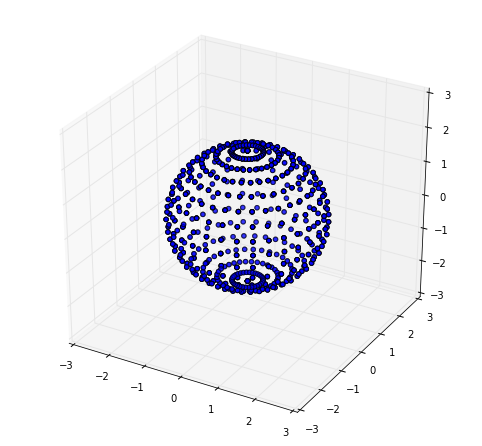

In [6]:
points.plot()

In [7]:
df = pd.DataFrame([[i.calc(0),i.calc(1), i.n, index] for index, i in enumerate(vertexes)], 
                                          columns=["f0","f1","n","index"])
df['F0'] = df.f0.apply(np.imag)
df['F1'] = df.f1.apply(np.imag)

In [8]:
print("Chren number for eigen level 0 is {}".format(2*pi/df.F0.sum()))
print("Chren number for eigen level 1 is {}".format(2*pi/df.F1.sum()))

Chren number for eigen level 0 is -569.787710228417
Chren number for eigen level 1 is 569.7877102283941


In [3]:
n = 2
p = 1/3
t = 1
def d(a,b):
    return int(a==b)
def mat(theta, phi):
    ls = [[2*d(i,j)*cos(2*theta-2*pi*p*j) -(d(i+1,j)+d(i,j+1))-d(i+n-1,j)*exp(-1j*n*phi)-d(i,j+n-1)*exp(1j*n*phi) for i in range(1,n+1)] 
                 for j in range(1,n+1)]
    return np.matrix(ls)